![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 12 - RNN Architectures </center>
### <center> Image captioning </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/12_RNN_Architectures/MainImageCaptioning.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/12_RNN_Architectures/DeepLearningFramework ./DeepLearningFramework

In [4]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import torch
import torch.nn          as nn
import torch.optim       as optim
import torchtext

from torchtext.data.utils import get_tokenizer
from torchtext.vocab      import Vocab

### Load the data:

In [5]:
import _pickle as pickle

dData     = np.load('ImageCaptionData.npz')
mFeatures = dData['mX']

with open('ImageCaptionData.pkl', 'rb') as f:
    lCaption, lImageName = pickle.load(f)

mFeatures.shape, len(lCaption), len(lImageName)

((8091, 2048), 8091, 8091)

#### Plot some examples:

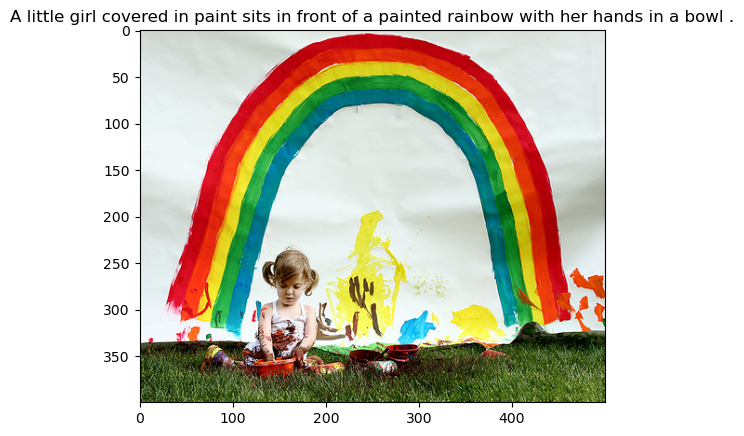

In [6]:
from PIL import Image

dirPath = r'C:\Users\oryai\Workarea\Data\Flicker8K\Images\\'
idx     = 2
oImage  = Image.open(dirPath + lImageName[idx])

plt.figure(figsize=(6, 6))
plt.imshow(oImage)
plt.title (lCaption[idx][0])
plt.show  ()

oImage.close()

#### Create dataset:

In [7]:
from torch.utils.data import Dataset

class ImageCaptionDataset(Dataset):
    def __init__(self, mFeatures, lCaption, lImageName):
        self.mFeatures  = torch.tensor(mFeatures, dtype=torch.float32)
        self.lCaption   = lCaption
        self.lImageName = lImageName

    def __len__(self):
        return len(self.lCaption)

    def __getitem__(self, idx):
        #-- Returns only one caption (out of the 5):
        return (self.mFeatures[idx,:], self.lCaption[idx][0], self.lImageName[idx])

In [8]:
oDataset            = ImageCaptionDataset(mFeatures, lCaption, lImageName)
N                   = len(oDataset)
oTrainSet, oTestSet = torch.utils.data.random_split(oDataset, np.round([0.9 * N, 0.1 * N]).astype(int), generator=torch.Generator().manual_seed(1))

nTrain = len(oTrainSet)
nTest  = len(oTestSet)
nTrain, nTest

(7282, 809)

In [9]:
oTrainSet[15]

(tensor([0.4905, 0.6021, 0.4289,  ..., 0.3964, 0.0405, 0.0052]),
 'A black and white dog is running between yellow poles .',
 '2935703360_4f794f7f09.jpg')

#### Make vocabulary:

In [10]:
from torchtext.vocab import build_vocab_from_iterator

oTokenizer = get_tokenizer('basic_english')

def YieldTokens(lDataset):
    for (vFi, caption, name) in lDataset:
        yield oTokenizer(caption)

oVocab = build_vocab_from_iterator(YieldTokens(oTrainSet), min_freq=5, specials=('<UNK>', '<SOS>', '<EOS>', '<PAD>'))
oVocab.set_default_index(oVocab['<UNK>'])
len(oVocab)

1139

In [11]:
def Line2Tensor(line):
    lLine = ['<SOS>'] + [token for token in oTokenizer(line)] + ['<EOS>']
    return torch.tensor(oVocab(lLine))
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
def Tensor2Line(vFi):
    return ' '.join([oVocab.get_itos()[e] for e in vFi])
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
line = 'A black dog and a white cat'
print('Input :', line)
print('Output:', Line2Tensor(line))
print('Back  :', Tensor2Line(Line2Tensor(line)))

Input : A black dog and a white cat
Output: tensor([  1,   4,  15,  11,   9,   4,  18, 580,   2])
Back  : <SOS> a black dog and a white cat <EOS>


#### Make data loader:
We pad all caption to have the same length

In [12]:
from torch.nn.utils.rnn import pad_sequence

def Collate(lBatch):
    lFeatures, lCaption, _ = zip(*lBatch) #-- (vFi, caption, fileName)
    mFeatures = torch.stack(lFeatures)
    lCaption  = [Line2Tensor(caption) for caption in lCaption]
    mCaption  = pad_sequence(lCaption, padding_value=oVocab['<PAD>'], batch_first=True)

    return mFeatures, mCaption

In [13]:
from torch.utils.data               import DataLoader

batchSize    = 64
oTrainDL     = DataLoader(oTrainSet, batch_size=batchSize,   shuffle=True, collate_fn=Collate)
oTestDL      = DataLoader(oTestSet,  batch_size=2*batchSize, shuffle=True, collate_fn=Collate)

mFeatures, mCaption = next(iter(oTrainDL))
mFeatures.shape, mCaption.shape

(torch.Size([64, 2048]), torch.Size([64, 28]))

### Define (RNN) decoder:
**Input**:  A <u>single</u> word (per sample in batch).  
**Output**: The next word and the next hidden state.  

In [17]:
#-- V = Vocabulary
#-- D = Embedding
#-- H = Hidden state
class DecoderRNN(nn.Module):
    def __init__(self, V, D, H):
        super().__init__()
        self.oEmbedding = nn.Embedding(V, D)
        self.oGRU       = nn.GRU      (D, H)
        self.oLinear    = nn.Linear   (H, V)
        
    def forward(self, vWord, mH):
                                               #-- vWord.shape = (N,)
                                               #-- mH   .shape = (1, N, H)
        mE     = self.oEmbedding(vWord)[None]  #-- mE   .shape = (1, N, D)
        _, mH  = self.oGRU      (mE, mH)       #-- mH   .shape = (1, N, H)
        mZ     = self.oLinear   (mH[-1])       #-- mZ   .shape = (N, V)
        return mZ, mH

#### Small test:

In [18]:
V   = len(oVocab)
D   = 256
H   = 2048

mH     = mFeatures[None]
vWord  = mCaption [:,0]
mZ, mH = DecoderRNN(V, D, H)(vWord, mH)

mZ.shape, mH.shape

(torch.Size([64, 1139]), torch.Size([1, 64, 2048]))

#### Full model:

In [20]:
#-- V = Vocabulary
#-- D = Embedding
#-- H = Hidden state
#-- T = Sequence length
class ImageCaptionModel(nn.Module):
    def __init__(self):
        super().__init__()
        V             = len(oVocab)
        D             = 64
        H             = 2048
        self.oDecoder = DecoderRNN(V, D, H)

    def forward(self, mFeatures, mCaption, pTeacher=0):
        device   = mFeatures.device
                                                          #-- mFeatures.shape = (N, H)
        N, T     = mCaption.shape                         #-- mCaption .shape = (N, T)
        mWordOut = torch.zeros((N, V, T), device=device)  #-- mHatOut  .shape = (N, V, T)

        mH       = mFeatures[None]                         #-- mH       .shape = (1, N, H)
        vWordIn  = torch.ones(N, device=device)            #-- vWordIn  .shape = (N,)
        vWordIn  = vWordIn.long() * oVocab['<SOS>']
        bTeacher = torch.rand(1) < pTeacher
        for ii in range(T):
            mZ, mH           = self.oDecoder(vWordIn, mH) #-- mZ.shape = (N, V)
                                                          #-- mH.shape = (L, N, H)
            mWordOut[:,:,ii] = mZ
           
            if bTeacher == True:
                vWordIn = mCaption[:,ii]                  #-- vWord.shape(N)
            else:
                vWordIn = mZ.argmax(1)                    #-- vWord.shape(N)
        
        return mWordOut
                
mWordOut = ImageCaptionModel()(mFeatures, mCaption, 0.5)
mWordOut.shape

torch.Size([64, 1139, 28])

In [21]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU


    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mFeatures, mCaption) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mFeatures = mFeatures.to(DEVICE)
        mCaption  = mCaption .to(DEVICE)

        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mOut = oModel(mFeatures, mCaption, pTeacher=0.5)
            loss = Loss  (mOut, mCaption)
            
            #-- Backward:
            vLR[ii] = oScheduler.get_last_lr()[0]
            oOptim    .zero_grad() #-- set gradients to zeros
            loss      .backward () #-- backward
            oOptim    .step     () #-- update parameters
            oScheduler.step     () #-- update learning rate
            
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mOut = oModel(mFeatures, mCaption, pTeacher=0)
                loss = Loss  (mOut, mCaption)

        with torch.no_grad():
            Nb           = mFeatures.shape[0]
            count       += Nb
            epochLoss   += Nb * loss.item()
            epochMetric += Nb * Metric(mOut, mCaption)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [22]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel
from DeepLearningFramework.Metric   import Accuracy

DEVICE = torch.device       ("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.CrossEntropyLoss(ignore_index=oVocab['<PAD>'])
Metric = Accuracy           (ignoreIndex =oVocab['<PAD>'])

In [23]:
nEpochs    = 100
nIter      = nEpochs * len(oTrainDL)

oModel     = ImageCaptionModel().to(DEVICE)
oOptim     = optim.AdamW      (oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=10)
oScheduler = OneCycleLR       (oOptim, max_lr=2e-5, total_steps=nIter)
lHistory   = TrainModel       (oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, Epoch=Epoch, sModelName='ImageCaptioning')

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  7.030 | Val loss:  6.981 | Train Metric:  0.002 | Val Metric:  0.013 | epoch time:  8.010 | <-- Checkpoint!
Epoch 001: | Train loss:  6.928 | Val loss:  6.867 | Train Metric:  0.059 | Val Metric:  0.071 | epoch time:  7.426 | <-- Checkpoint!
Epoch 002: | Train loss:  6.794 | Val loss:  6.702 | Train Metric:  0.109 | Val Metric:  0.145 | epoch time:  7.589 | <-- Checkpoint!
Epoch 003: | Train loss:  6.609 | Val loss:  6.464 | Train Metric:  0.140 | Val Metric:  0.153 | epoch time:  7.214 | <-- Checkpoint!
Epoch 004: | Train loss:  6.357 | Val loss:  6.122 | Train Metric:  0.193 | Val Metric:  0.205 | epoch time:  7.193 | <-- Checkpoint!
Epoch 005: | Train loss:  5.922 | Val loss:  5.475 | Train Metric:  0.214 | Val Metric:  0.206 | epoch time:  7.237 | <-- Checkpoint!
Epoch 006: | Train loss:  5.147 | Val loss:  4.650 | Train Metric:  0.206 |

Epoch 061: | Train loss:  3.356 | Val loss:  3.581 | Train Metric:  0.332 | Val Metric:  0.295 | epoch time:  7.055 | <-- Checkpoint!
Epoch 062: | Train loss:  3.338 | Val loss:  3.583 | Train Metric:  0.336 | Val Metric:  0.288 | epoch time:  7.052 |
Epoch 063: | Train loss:  3.308 | Val loss:  3.585 | Train Metric:  0.344 | Val Metric:  0.291 | epoch time:  7.049 |
Epoch 064: | Train loss:  3.331 | Val loss:  3.578 | Train Metric:  0.338 | Val Metric:  0.290 | epoch time:  7.115 |
Epoch 065: | Train loss:  3.305 | Val loss:  3.584 | Train Metric:  0.345 | Val Metric:  0.289 | epoch time:  7.232 |
Epoch 066: | Train loss:  3.309 | Val loss:  3.584 | Train Metric:  0.344 | Val Metric:  0.289 | epoch time:  7.404 |
Epoch 067: | Train loss:  3.304 | Val loss:  3.582 | Train Metric:  0.343 | Val Metric:  0.288 | epoch time:  7.074 |
Epoch 068: | Train loss:  3.310 | Val loss:  3.582 | Train Metric:  0.342 | Val Metric:  0.288 | epoch time:  7.054 |
Epoch 069: | Train loss:  3.324 | Val lo

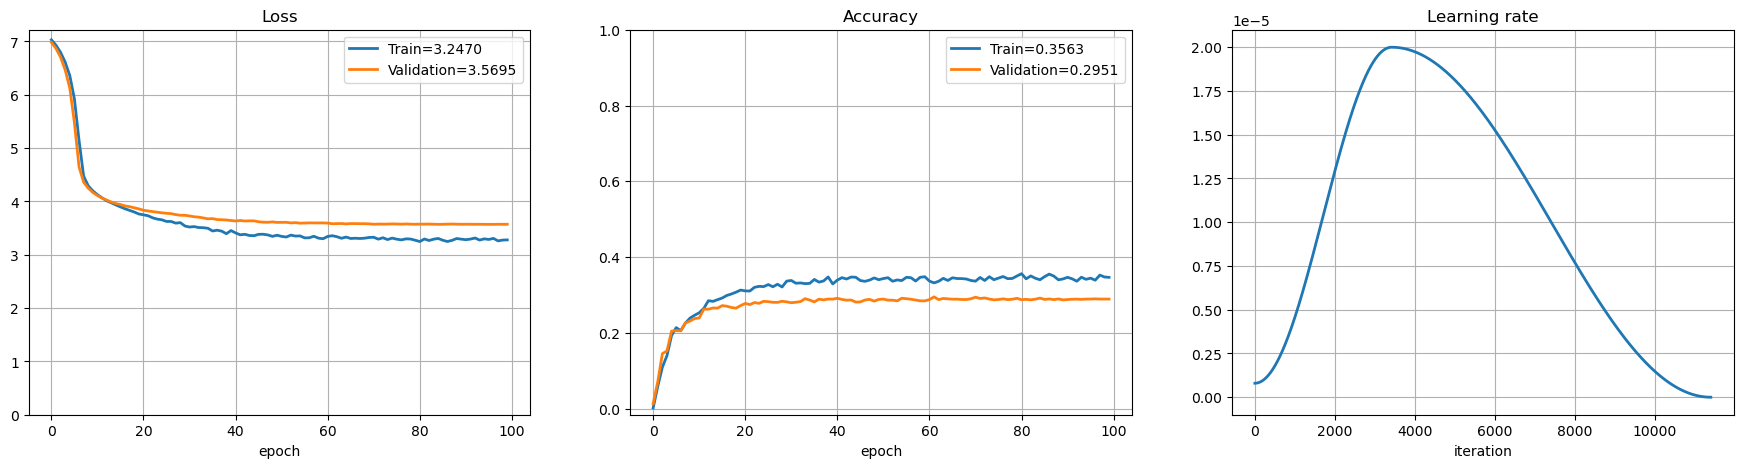

In [24]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

In [55]:
# oMdeol = ImageCaptionModel().to(DEVICE)
# oModel.load_state_dict(torch.load('ImageCaptioning_v1.pt'))
# oModel.eval()

ImageCaptionModel(
  (oDecoder): RnnDecoder(
    (oEmbedding): Embedding(1139, 64)
    (oGRU): GRU(64, 2048)
    (oFC): Linear(in_features=2048, out_features=1139, bias=True)
  )
)

### Exercise (predict implementation)
Complete the `Predict` function implementation.  

Note: A [beam search](https://en.wikipedia.org/wiki/Beam_search) should be used instead of top 1 method.

In [34]:
from torch.distributions.categorical import Categorical

def Predict(oModel, vFeatures, bTop1=False):
    '''
    Input:
        oModel    - A trained model with oModel.oDecoder.
        vFeatures - Features of a single image.            
        bTop1     - Boolean, whether to use the top prediction or a multinomial prediction.
        
        #-- vFeatures.shape = (H,)
    Output:
        vWordsOut - The output caption.
        
        #-- vWordsOut.shape = (T,) where T < MAX_LENGTH
    '''
    MAX_LENGTH = 256
    device     = vFeatures.device                          #-- CPU \ GPU
    vWordsOut  = torch.empty((MAX_LENGTH,), device=device) #-- vWordsOut.shape = (T,)

    #-- Initialization:
    mH     = ???                              #-- mH     .shape = (1, 1, H)
    wordIn = torch.tensor(??? device=device)  #-- vWordIn.shape = (1,)
    
    #-- Apply model:
    for ii in range(MAX_LENGTH):
        vZ, mH = oModel.??? #-- mZ.shape = (1, V)
                            #-- mH.shape = (L, 1, H)
            
        #-- Get prediction:
        if bTop1 == True:
            wordIn = ???                             #-- top prediction
        else:
            wordIn = Categorical(logits=vZ).sample() #-- random prediction

        if wordIn == oVocab['<EOS>']:
            break

        vWordsOut[ii] = wordIn

    return vWordsOut[:ii]

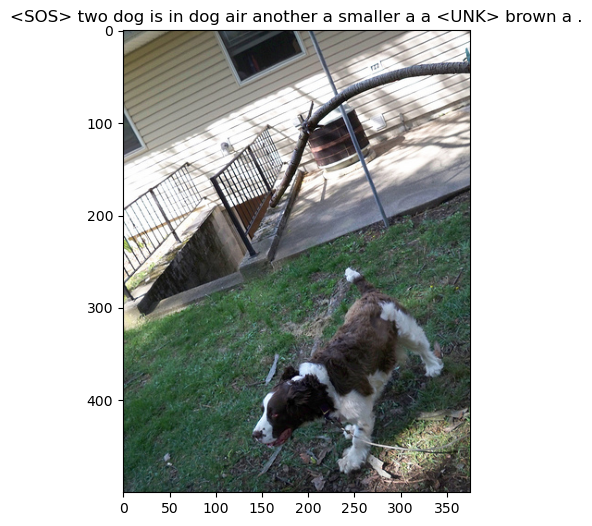

In [32]:
idx                   = np.random.randint(nTest)
vFi, _, imageFileName = oTestSet[idx]
# vFi, _, imageFileName = oTrainSet[idx]
vFi                   = vFi.to(DEVICE)

with torch.no_grad():
    vWordOut  = Predict(oModel, vFi, bTop1=False)
    
sCaption = Tensor2Line(vWordOut.int())
oImage   = Image.open(dirPath + imageFileName)

plt.figure(figsize=(6, 6))
plt.imshow(oImage)
plt.title (sCaption)
plt.show  ()

oImage.close()

In [ ]:
# from torch.distributions.categorical import Categorical

# def Predict(oModel, vFeatures, bTop1=False):
#     '''
#     Input:
#         oModel    - A trained model with oModel.oDecoder.
#         vFeatures - Features of a single image.            
#         bTop1     - Boolean, whether to use the top prediction or a multinomial prediction.
        
#         #-- vFeatures.shape = (H,)
#     Output:
#         vWordsOut     - The output caption.
        
#         #-- vWordsOut.shape = (T,) where T < MAX_LENGTH
#     '''
#     MAX_LENGTH = 256
#     device     = vFeatures.device                          #-- CPU \ GPU
#     vWordsOut  = torch.empty((MAX_LENGTH,), device=device) #-- vWordsOut.shape = (T,)

#     #-- Initialization:
#     mH     = vFeatures[None,None,:]                          #-- mH     .shape = (1, 1, H)
#     wordIn = torch.tensor([oVocab['<SOS>']], device=device)  #-- vWordIn.shape = (1)
    
#     #-- Apply model:
#     for ii in range(MAX_LENGTH):
#         vZ, mH = oModel.oDecoder(wordIn, mH)            #-- mZ.shape = (1, V)
#                                                         #-- mH.shape = (L, 1, H)
            
#         #-- Get prediction:
#         if bTop1 == True:
#             wordIn = vZ.argmax(1)                       #-- wordIn.shape(1,)
#         else:
#             wordIn = Categorical(logits=vZ).sample()

#         if wordIn == oVocab['<EOS>']:
#             break

#         vWordsOut[ii] = wordIn

#     return vWordsOut[:ii]